# DATA ENGINEERING: Stock Prediction

* HCMUT-VNU
* Semester: 231
* Group 17

# 0. Get data

In [1]:
# !python3.10 crawl-data.py

# 1. Data fields

There are some data fields that VN30 provided. They are described as below:

+ Ngày: Gồm ngày tháng năm cụ thể.

+ Lần cuối: Hay còn gọi là "Giá đóng"(close price), có nghĩa là giá cổ phiếu của phiên giao dịch cuối của ngày đó.

+ Mở: Hay còn gọi là "Giá mở"(open price), có nghĩa là giá cổ phiếu của phiên giao dịch đầu của ngày đó.

+ Cao: Hay còn gọi là "Giá trần", có nghĩa là giá cổ phiếu cao nhất trong ngày.

+ Thấp: Hay còn gọi là "Giá sàn", có nghĩa là giá cổ phiếu thấp nhất trong ngày.

+ KL: Số lượng giao dịch trong ngày của cổ phiếu.

+ % Thay đổi: Phần trăm thay đổi của giá đóng của ngày hôm sau so với ngày hiện tại.


Also, there are some fields that we can derive:

## RSI 
- Đây là "Chỉ số sức mạnh tương đối"(Relevant Strength Index) là giá trị phản ánh tình trạng quá "mua" hoặc quá "bán" trên thị trường. Có công thức như sau:

$$RSI=100-[\dfrac{100}{1+\dfrac{\text{Mức tăng trung bình}}{\text{Tổn thất trung bình}}}]$$

- Giá trị của RSI được biểu diễn trong khoảng từ 0 đến 100. Thông thường:

    + Nếu RSI > 70, thì cổ phiếu đang bị mua quá mức dẫn đến việc xu hướng tăng của giá trị cổ phiếu có khả năng bị giảm và xu hướng giảm có khả năng tăng.

    + Nếu RSI < 30, thì cổ phiếu đang bị bán quá mức dẫn đến giá trị cổ phiếu gần chạm đáy và chuẩn bị tăng.
    
    + Nếu RSI giữa khoảng (30,70) được coi là trung tính. Ví dụ với mức RSI=50 thì xem là không có xu hướng.

- Bên cạnh việc thể hiện tình trạng quá bán hoặc quá mua, nhà đầu tư cũng có thể sử dụng phân kỳ RSI để dự đoán xu hướng đảo chiều. Sự phân kỳ xảy ra khi giá chứng khoán di chuyển theo hướng ngược lại so với các chỉ báo kỹ thuật. Điều này cảnh báo xu hướng giá hiện tại có thể đang suy yếu và nguy cơ dẫn đến sự thay đổi hướng của giá. Trong đó có hai loại là phân kỳ âm và phân kỳ dương:

    + Phân kỳ dương: RSI tăng tạo đáy cao trong khi giá giảm tạo đáy thấp, cảnh báo đà tăng mạnh bất chấp xu hướng giá giảm.

    + Phân kỳ âm: RSI giảm và tạo đỉnh thấp trong khi giá tài sản tăng tạo đỉnh cao hơn, cảnh báo giá có thể giảm mạnh.


## EMA

- Đây là "Đường trung bình động luỹ thừa"(Exponent Moving Average). Nó được dùng để phản ánh sự biến động giá được tính theo cấp số nhân, qua đó giúp nhà đầu tư xác định được sự biến động giá một cách chuẩn xác hơn và giảm thiểu được tình trạng nhiễu giá so với đường trung bình động thông thường. 

- Có công thức:

$$\text{EMA}(t)=P(t) \times K + \text{EMA}(t-1) \times (1-K)$$

- Với:

    + $P(t)$: giá đóng của cổ phiếu ở ngày t.
 
    + $K=\dfrac{2}{1+N}$: hệ số làm trơn, được tính bằng công thức đính kèm với N là chu kì (ví dụ như 5 ngày, 10 ngày,...).
 
    + EMA(t): giá trị EMA tại ngày t.

- Sự di chuyển của đường EMA phản ánh xu hướng dịch chuyển của giá, thông qua đó nhà đầu tư nắm bắt tình hình xu hướng giá ngay thời điểm hiện tại.

- Đường EMA dốc lên thể hiện giá đang đi lên, thị trường trong xu hướng tăng. Ngược lại, đường EMA dốc xuống thể hiện giá đang đi xuống, thị trường trong xu hướng giảm. Đường EMA nằm ngang đồng nghĩa với giá cũng đi ngang, thị trường trong trạng thái sideway.

- EMA được theo 3 khung thời gian gồm có:

    + EMAF: EMA nhanh, thường tương ứng với các chu kỳ nhỏ.
    
    + EMAM: EMA trung bình, thường tương ứng với các chu kỳ trung bình.
    + EMAS: EMA chậm, thường tương ứng với chu kỳ lớn.

- Dựa vào sự cắt nhau của các đường EMAF, EMAM, EMAS và đường giá, ta sẽ xác định được xu hướng tăng hoặc giảm của cổ phiếu đó.

# 2. Data processing

## PRE-PROCESING FOR **VN30** FIRST, THEN WE CAN APPLY THE PRE-PROCESSING STEP FOR **VNI** AND **HNX30**

### Import Libraries

In [2]:
# !pip3 install numpy matplotlib yfinance
# !pip3 install -U git+https://github.com/twopirllc/pandas-ta.git@development
# !pip3 install seaborn
# !pip3 install plotly
# !pip3 install nbformat
# !pip3 install scipy

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import pandas_ta as ta
import yfinance as yf
import seaborn as sns

### Import data

In [4]:
data_VN30 = pd.read_csv('./VN30_311222-010113.csv') # there are no null values in this CSV file
data_HNX30 = pd.read_csv('./HNX30_311222-010113.csv')
data_VNI = pd.read_csv('./VN_311222-010113.csv')

In [5]:
data_VN30.head(5)

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,30/12/2022,"1,005.19","1,016.71","1,017.45","1,005.19",95.62K,-0.31%
1,29/12/2022,"1,008.30","1,013.95","1,022.15","1,008.30",121.03K,-0.56%
2,28/12/2022,"1,013.95","1,009.19","1,023.24",997.12,123.26K,0.65%
3,27/12/2022,"1,007.36",988.87,"1,015.01",985.67,153.66K,1.98%
4,26/12/2022,987.77,"1,032.42","1,033.17",987.77,175.23K,-4.48%


In [6]:
data_HNX30.head(5)

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,31/01/2023,387.57,379.14,387.57,376.27,59.79K,2.36%
1,30/01/2023,378.63,378.74,387.43,374.18,72.88K,-0.06%
2,27/01/2023,378.87,379.27,387.81,378.20,46.37K,-0.02%
3,19/01/2023,378.94,373.53,379.98,373.04,51.80K,1.45%
4,18/01/2023,373.53,365.94,375.36,365.94,57.66K,1.98%


In [7]:
data_VNI.head(5)

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,30/12/2022,"1,007.09","1,009.29","1,017.99","1,007.09",407.14K,-0.22%
1,29/12/2022,"1,009.29","1,015.66","1,021.96","1,009.29",462.66K,-0.63%
2,28/12/2022,"1,015.66","1,004.57","1,020.52",998.97,590.45K,1.10%
3,27/12/2022,"1,004.57",985.21,"1,007.88",983.67,593.36K,1.97%
4,26/12/2022,985.21,"1,020.34","1,021.89",985.21,623.49K,-3.44%


### Rename columns

Change to avoid using utf-8 character.

In [8]:
def rename(data):
    data.rename(columns={
        'Ngày': 'Date', 
        'Lần cuối': 'Close',
        'Mở': 'Open',
        'Cao': 'High',
        'Thấp': 'Low',
        'KL': 'Vol',
        '% Thay đổi': 'PercentageChange'
        }, 
        inplace=True)
    return data

In [9]:
data_VN30 = rename(data_VN30)

In [10]:
data_VN30.head(3)

,Date,Close,Open,High,Low,Vol,PercentageChange
0,30/12/2022,"1,005.19","1,016.71","1,017.45","1,005.19",95.62K,-0.31%
1,29/12/2022,"1,008.30","1,013.95","1,022.15","1,008.30",121.03K,-0.56%
2,28/12/2022,"1,013.95","1,009.19","1,023.24",997.12,123.26K,0.65%


### As we can see, our data is being reversed

In [11]:
def reverseData(data):
    data = data.iloc[::-1]
    data.reset_index(drop=True, inplace=True)
    return data

In [12]:
data_VN30 = reverseData(data_VN30)
data_VN30

,Date,Close,Open,High,Low,Vol,PercentageChange
0,02/01/2013,490.82,486.41,492.29,485.37,22.64K,1.12%
1,03/01/2013,491.34,492.55,492.55,483.84,32.69K,0.11%
2,04/01/2013,498.31,489.71,499.85,487.95,20.15K,1.42%
3,07/01/2013,509.18,500.58,509.61,498.54,26.03K,2.18%
4,08/01/2013,525.36,512.41,525.36,511.64,32.89K,3.18%
...,...,...,...,...,...,...,...
2491,26/12/2022,987.77,"1,032.42","1,033.17",987.77,175.23K,-4.48%
2492,27/12/2022,"1,007.36",988.87,"1,015.01",985.67,153.66K,1.98%
2493,28/12/2022,"1,013.95","1,009.19","1,023.24",997.12,123.26K,0.65%
2494,29/12/2022,"1,008.30","1,013.95","1,022.15","1,008.30",121.03K,-0.56%


### Get data types:

In [13]:
data_VN30.dtypes

Date                object
Close               object
Open                object
High                object
Low                 object
Vol                 object
PercentageChange    object
dtype: object

In [14]:
data_VN30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              2496 non-null   object
 1   Close             2496 non-null   object
 2   Open              2496 non-null   object
 3   High              2496 non-null   object
 4   Low               2496 non-null   object
 5   Vol               2496 non-null   object
 6   PercentageChange  2496 non-null   object
dtypes: object(7)
memory usage: 136.6+ KB


As we can see, **Open**, **Close**, **High**, **Low** price got the same string format, but how about **Vol** ?

In [15]:
data_VN30['Vol'].str[-1].value_counts()

Vol
K    2491
M       5
Name: count, dtype: int64

There are 2 different values in **Vol**:
- K: Increase 1000 times.
- M: Increase 1000_000 times.

Convert data types:

In [16]:
def convertDataType(data):
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

    data['Close'] = data['Close'].astype(str)
    data['Open'] = data['Open'].astype(str)
    data['High'] = data['High'].astype(str)
    data['Low'] = data['Low'].astype(str)

    data['Close'] = pd.to_numeric(data['Close'].str.replace(',',''))
    data['Open'] = pd.to_numeric(data['Open'].str.replace(',',''))
    data['High'] = pd.to_numeric(data['High'].str.replace(',',''))
    data['Low'] = pd.to_numeric(data['Low'].str.replace(',',''))

    data['PercentageChange'] = data['PercentageChange'].str.replace('%', '')
    data['PercentageChange'] = pd.to_numeric(data['PercentageChange']) # if null then NaN

    # Convert Volume
    data['Vol'] = data['Vol'].astype(str)

    for i in range(len(data['Vol'])):
        if data['Vol'].loc[i][-1] == 'K':
            data.loc[i, 'Vol'] = int(float(data['Vol'].loc[i].replace('K', '')) * 1000)
        else:
            data.loc[i, 'Vol'] = int(float(data['Vol'].loc[i].replace('M', '')) * 1000000)

    data['Vol'] = data['Vol'].astype(int)


    return data 

In [17]:
data_VN30 = convertDataType(data_VN30)

In [18]:
data_VN30.dtypes

Date                datetime64[ns]
Close                      float64
Open                       float64
High                       float64
Low                        float64
Vol                          int64
PercentageChange           float64
dtype: object

## Now do the same for **VNI** and **HNX30**:

In [19]:
# rename
data_VNI = rename(data_VNI)
data_HNX30 = rename(data_HNX30)
# reverse
data_VNI = reverseData(data_VNI)
data_HNX30 = reverseData(data_HNX30)
# convert
data_VNI = convertDataType(data_VNI)
data_HNX30 = convertDataType(data_HNX30)

## After converting data we can describe these stastistics

In [20]:
data_VN30.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,2496,2018-01-06 21:46:43.846153728,2013-01-02 00:00:00,2015-07-14 18:00:00,2018-01-03 12:00:00,2020-07-08 06:00:00,2022-12-30 00:00:00,NaN
Close,2496.0,853.710541,490.82,617.9025,790.59,973.885,1572.46,288.461699
Open,2496.0,853.719988,486.41,618.03,790.745,971.905,1576.52,288.653138
High,2496.0,859.760405,492.29,621.8675,795.505,981.3375,1587.0,291.021923
Low,2496.0,847.19234,483.84,614.2125,786.005,966.425,1567.67,285.634509
Vol,2496.0,136499.495192,6710.0,37320.0,52935.0,98347.5,34390000.0,1286973.97541
PercentageChange,2496.0,0.03643,-6.73,-0.51,0.11,0.6725,5.31,1.205359


In [21]:
data_VNI.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,2496,2018-01-06 21:46:43.846153728,2013-01-02 00:00:00,2015-07-14 18:00:00,2018-01-03 12:00:00,2020-07-08 06:00:00,2022-12-30 00:00:00,NaN
Close,2496.0,849.266595,418.35,588.5225,829.045,1006.0275,1528.57,285.782573
Open,2496.0,849.247961,415.5,589.0275,827.8,1006.185,1534.1,285.927427
High,2496.0,854.845917,419.05,591.8475,836.07,1012.1925,1536.45,288.014713
Low,2496.0,843.166378,413.68,585.7375,821.33,998.595,1524.96,283.122148
Vol,2496.0,491994.002003,25840.0,117507.5,175330.0,344542.5,121250000.0,4727753.337311
PercentageChange,2496.0,0.042416,-6.67,-0.44,0.12,0.6525,4.98,1.156728


In [22]:
data_HNX30.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,2057,2018-12-16 23:22:11.842488832,2014-11-04 00:00:00,2016-11-24 00:00:00,2018-12-12 00:00:00,2020-12-31 00:00:00,2023-01-31 00:00:00,NaN
Close,2057.0,271.73665,125.07,164.85,193.26,299.9,874.02,172.202553
Open,2057.0,271.530462,124.58,164.53,193.2,299.59,874.02,172.198999
High,2057.0,275.002154,127.51,166.53,194.83,304.76,892.18,175.128033
Low,2057.0,268.323991,123.49,163.21,191.74,291.47,851.04,169.48012
Vol,2057.0,33501.726787,5900.0,17280.0,26520.0,43030.0,162660.0,22546.141237
PercentageChange,2057.0,0.051415,-8.2,-0.65,0.15,0.85,6.98,1.630779


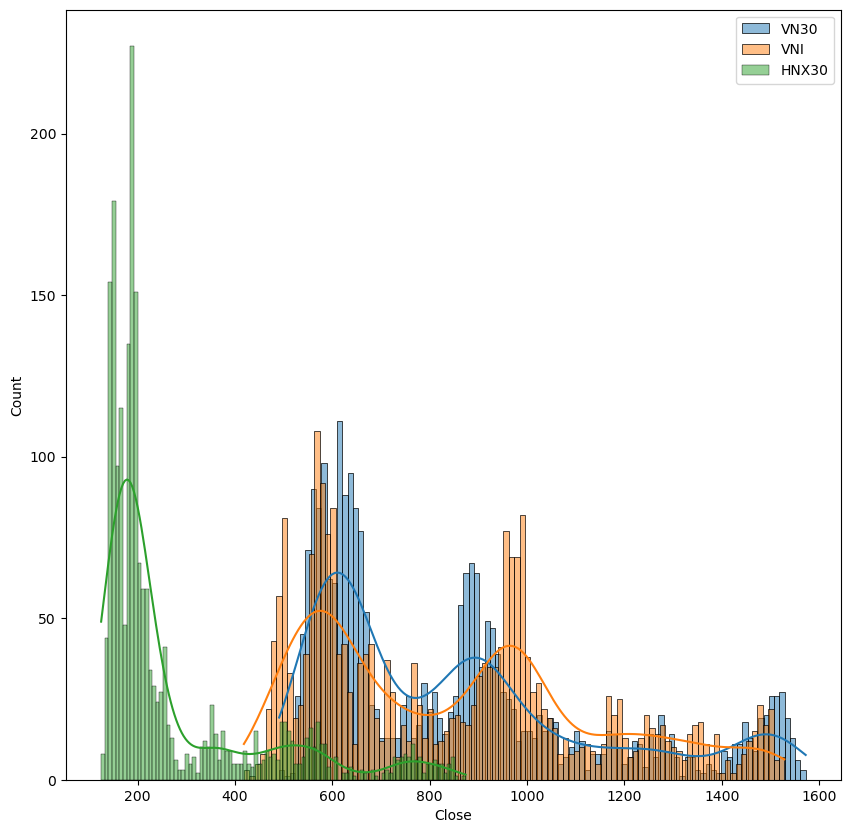

In [23]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_figure
# Plot the first distribution
sns.histplot(data_VN30['Close'], bins=100, kde=True, ax=ax, label='VN30')
# Plot the second distribution on the same axis
sns.histplot(data_VNI['Close'], bins=100, kde=True, ax=ax, label='VNI')
# Plot the third distribution on the same axis
sns.histplot(data_HNX30['Close'], bins=100, kde=True, ax=ax, label='HNX30')
# Add a legend
ax.legend()
# Show the plot
plt.show()

### Number of record of each year from 01/01/2013 to 31/12/2022:

In [24]:
def volumePlot(data):
    vols = []
    for i in range (2013,2023):
        print(i,data[data['Date'].dt.year==i].size)
        vols += [[i,data[data['Date'].dt.year==i].size]]
    vols = pd.DataFrame({
    'Year': [vols[i][0] for i in range(len(vols))],
    'NumberOfTrades': [vols[i][1] for i in range(len(vols))]
    } )
    sns.barplot(vols, x="Year", y="NumberOfTrades")


2013 0
2014 294
2015 1736
2016 1757
2017 1750
2018 1750
2019 1750
2020 1764
2021 1750
2022 1736


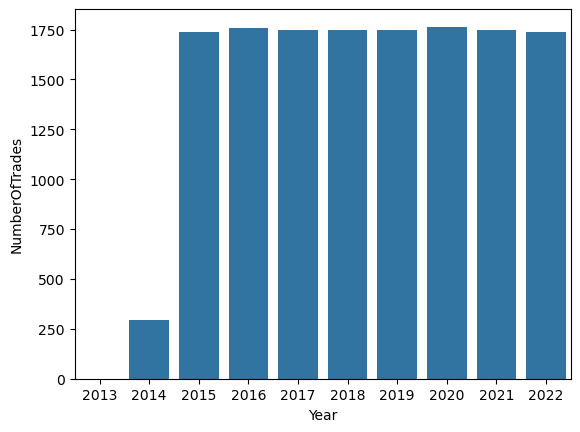

In [25]:
volumePlot(data_HNX30)

2013 1750
2014 1729
2015 1736
2016 1757
2017 1750
2018 1743
2019 1750
2020 1764
2021 1750
2022 1743


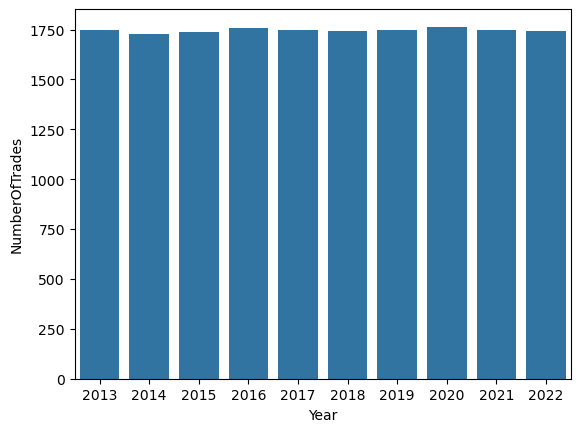

In [26]:
volumePlot(data_VN30)

2013 1750
2014 1729
2015 1736
2016 1757
2017 1750
2018 1743
2019 1750
2020 1764
2021 1750
2022 1743


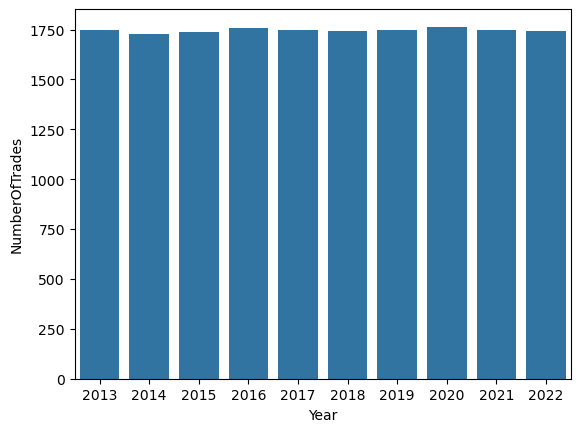

In [27]:
volumePlot(data_VNI)

### Attributes Distribution

In [28]:
def attributeDistributionPlot(data):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Price-related attributes box plots
    sns.boxplot(x="variable", y="value", data=pd.melt(data[['Close', 'Open', 'High', 'Low']]), ax=axes[0])
    axes[0].set_title('Price-related Attributes')

    # 'Volume' box plot
    sns.boxplot(x="Vol", data=data, ax=axes[1])
    axes[1].set_title('Volume')

    plt.tight_layout()
    plt.show()


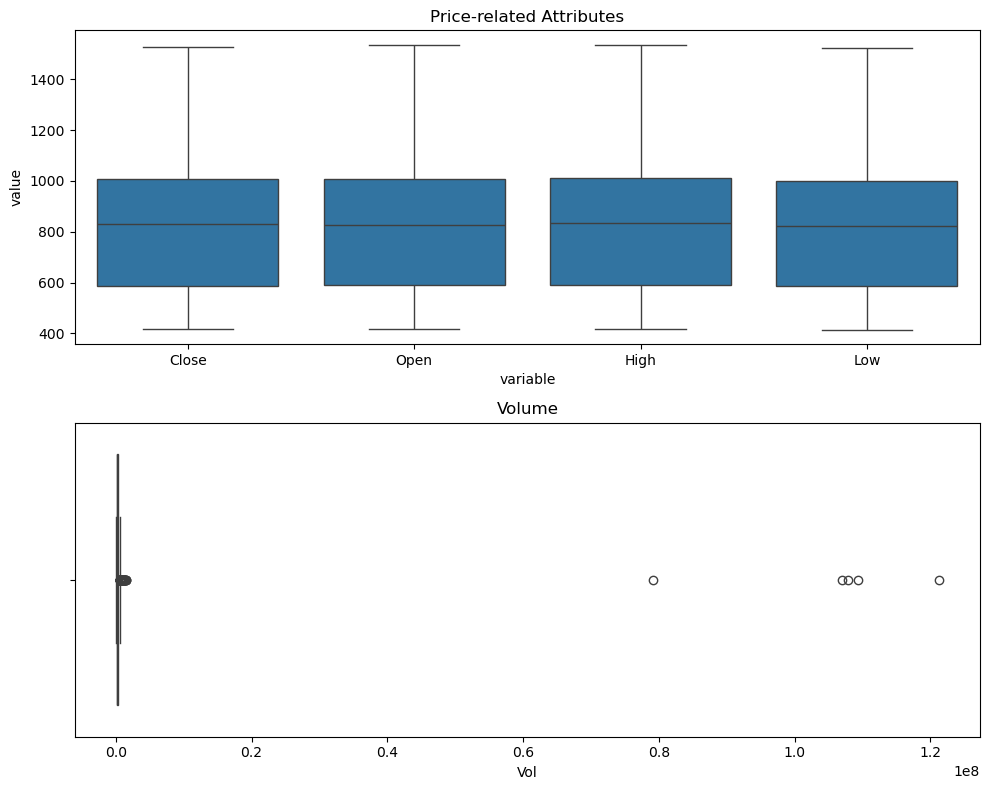

In [29]:
attributeDistributionPlot(data_VNI)

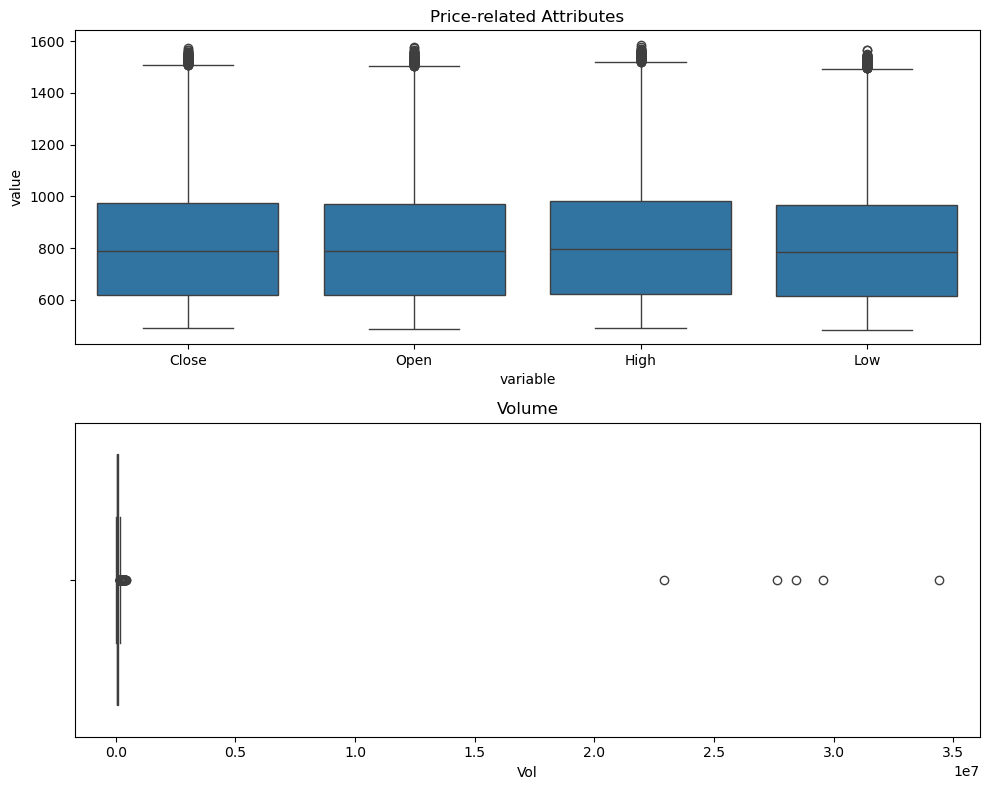

In [30]:
attributeDistributionPlot(data_VN30)

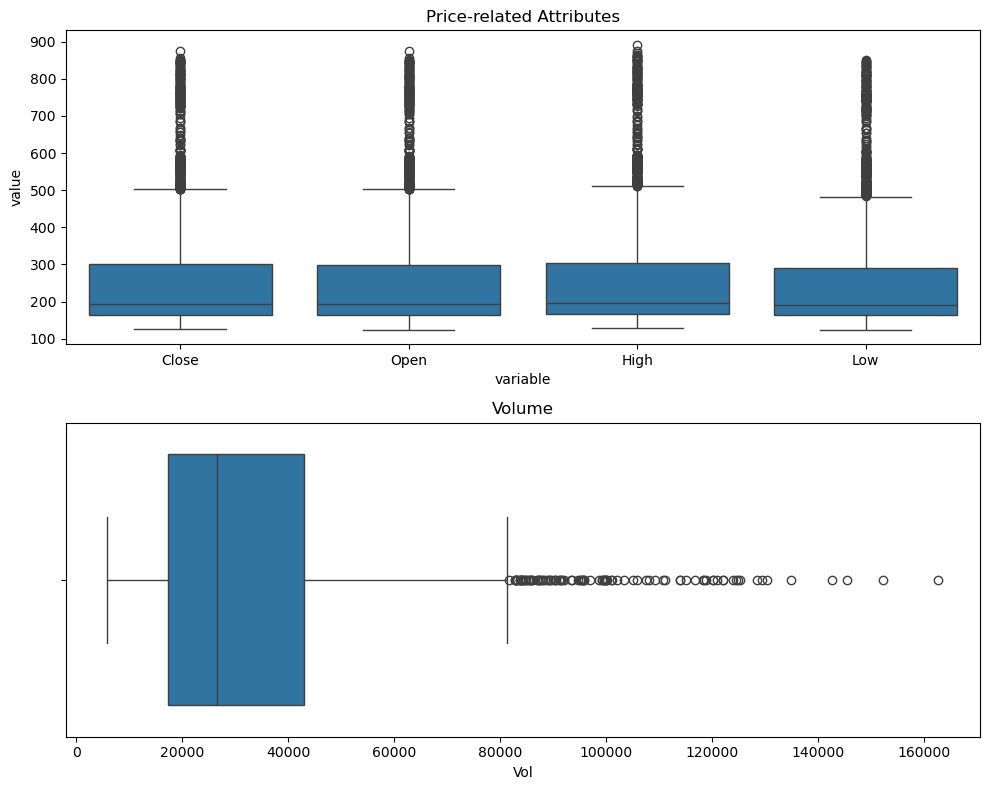

In [31]:
attributeDistributionPlot(data_HNX30)

## Percentage change each day distribution

In [32]:
def PercentChangeDistributionPlot(data):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    sns.boxplot(y="PercentageChange", data=data, ax=axes)
    axes.set_title('Percentage change distribution')
    plt.tight_layout()
    plt.show()


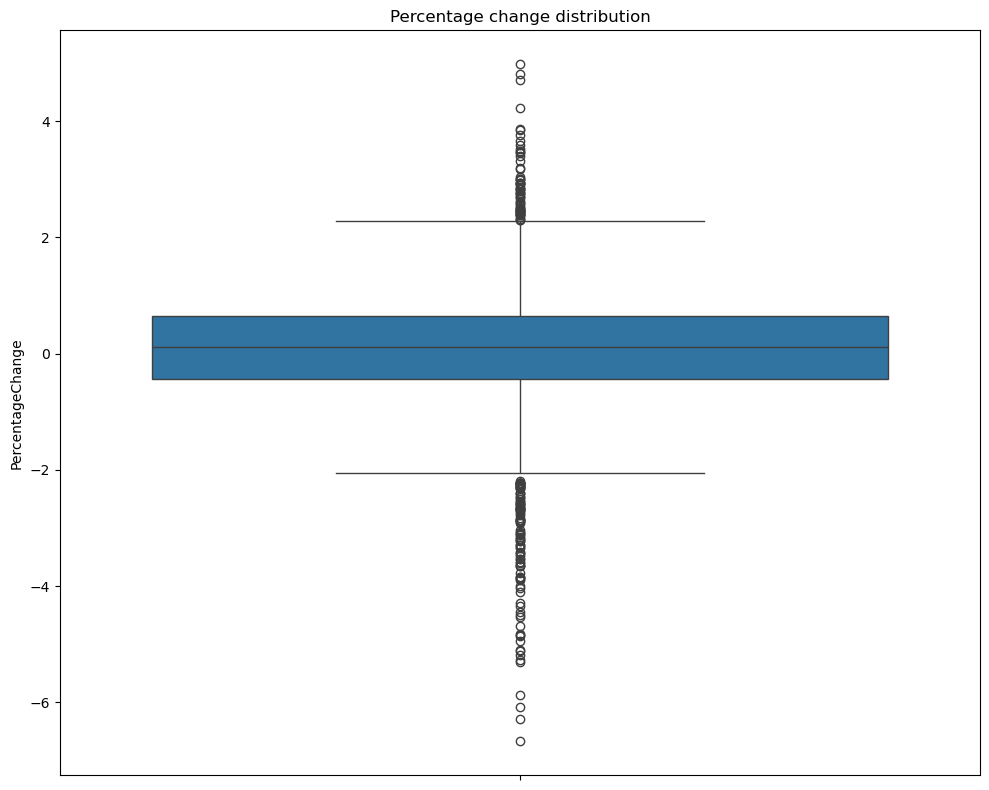

In [33]:
PercentChangeDistributionPlot(data_VNI)

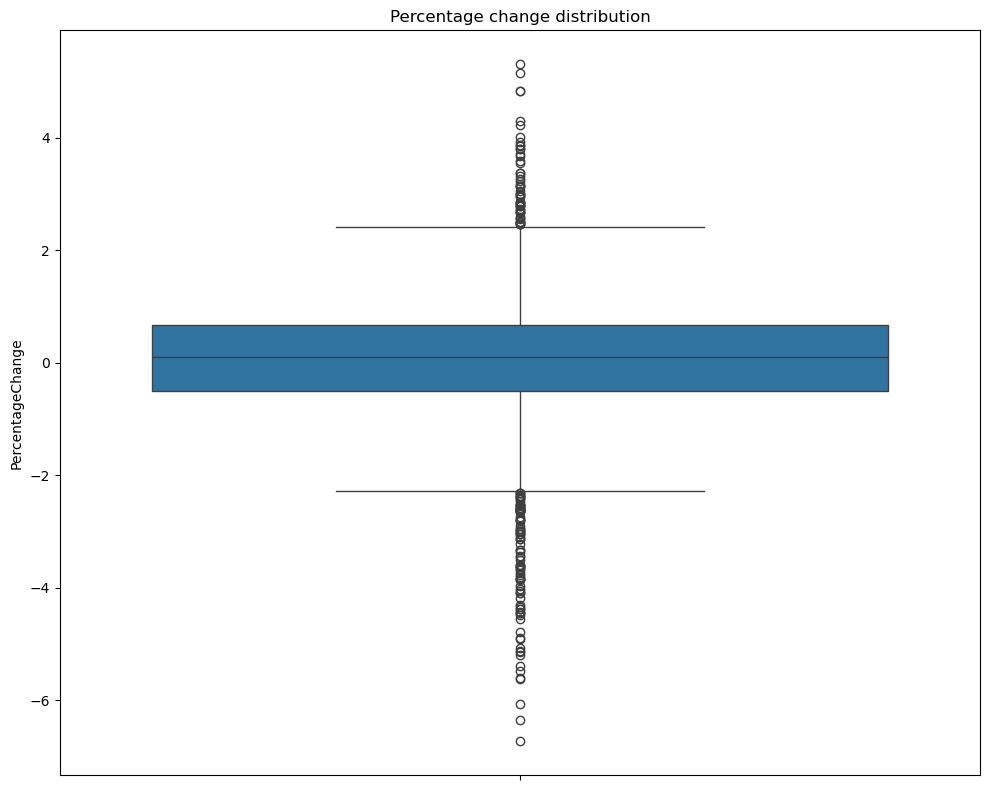

In [34]:
PercentChangeDistributionPlot(data_VN30)

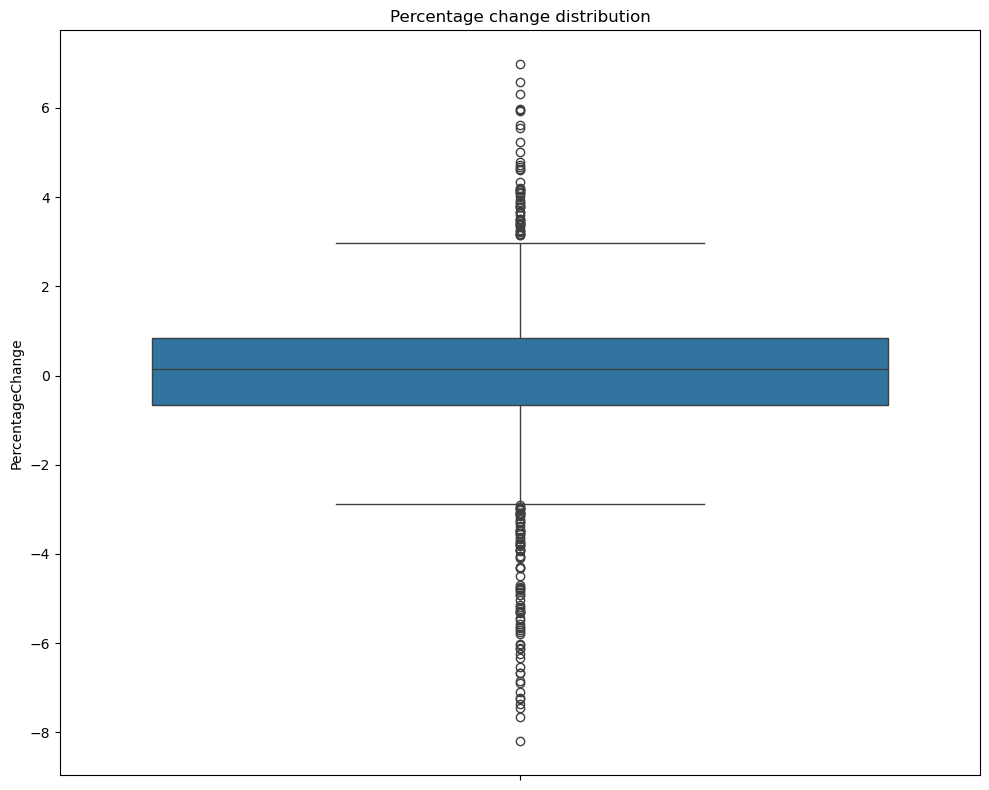

In [35]:
PercentChangeDistributionPlot(data_HNX30)

## Candlesticks

In [36]:
import plotly.graph_objects as go

def candlestick_plot(data):
    fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close'])])
    fig.show()

def candlestick_plot_from_to(data, from_year=2013, to_year=2023):
    for i in range(from_year, to_year):
        subset = data[data['Date'].dt.year == i]
        candlestick_plot(subset)

In [37]:
candlestick_plot_from_to(data_HNX30)

In [38]:
candlestick_plot_from_to(data_VN30)

In [39]:
candlestick_plot_from_to(data_VNI)

### Number of trade for each day (of week):

In [40]:
def numOfTradeEachDay(data):
    df = data.copy()
    df['dayofweek'] = df['Date'].dt.dayofweek
    print(df.groupby('dayofweek').agg({'Vol':['sum']}))

In [41]:
numOfTradeEachDay(data_VN30)

                Vol
                sum
dayofweek          
0          69340174
1          74621034
2          66371216
3          67129181
4          63241135


In [42]:
numOfTradeEachDay(data_VNI)

                 Vol
                 sum
dayofweek           
0          250771098
1          266102798
2          248013506
3          242849761
4          220279866


In [43]:
numOfTradeEachDay(data_HNX30)

                Vol
                sum
dayofweek          
0          13906058
1          14388877
2          13614634
3          13341294
4          13662189


As we can see, there are no Saturday and Sunday but there are lots of trade on Mon and Tues.

### Add Stock indicators

* RSI:

Choose t period:

In [44]:
def find_RSI_Period(data):
    for i in range(5,31):
        df = data.copy()
        df['RSI'] = ta.rsi(df.Close, length=i)
        df['NextClose'] = df['Close'].shift(-1)
        df.dropna(inplace=True)
        
        print(i,':',df['RSI'].corr(df['NextClose']))

In [45]:
find_RSI_Period(data_HNX30)

5 : 0.10473471151879489
6 : 0.10899879870728062
7 : 0.11296276054711525
8 : 0.11675982839316791
9 : 0.12044045493929156
10 : 0.1240246884488847
11 : 0.12752232044149128
12 : 0.13094029047876887
13 : 0.1342850499139761
14 : 0.1375630468012428
15 : 0.14078061856545784
16 : 0.14394378090102788
17 : 0.14705806788151063
18 : 0.15012844934486394
19 : 0.15315931017852824
20 : 0.15615446904454353
21 : 0.15911721821022135
22 : 0.1620503722709029
23 : 0.164956318615364
24 : 0.16783706591902436
25 : 0.17069428901746247
26 : 0.17352936964096102
27 : 0.1763434330450596
28 : 0.17913738080648675
29 : 0.1819119201257424
30 : 0.18466758997614677


HNX: 30 ngày

In [46]:
find_RSI_Period(data_VN30)

5 : 0.02312110456497428
6 : 0.024354190582291404
7 : 0.02550724790673899
8 : 0.02659809506937343
9 : 0.027620620163886687
10 : 0.02856580429449786
11 : 0.029430534429098404
12 : 0.030218979164786625
13 : 0.030940898553258354
14 : 0.031609287298352814
15 : 0.03223833347546586
16 : 0.03284195606677569
17 : 0.03343289069416946
18 : 0.034022202871254646
19 : 0.034619101597009996
20 : 0.035230947672704106
21 : 0.03586337787079464
22 : 0.03652048980925332
23 : 0.03720505096027726
24 : 0.03791870882199922
25 : 0.03866218879501803
26 : 0.039435472713364395
27 : 0.04023795513563354
28 : 0.041068577079899506
29 : 0.04192593838891915
30 : 0.04280839070299415


VN30: 30 ngày

In [47]:
find_RSI_Period(data_VNI)

5 : 0.028967521730602807
6 : 0.027228516925966412
7 : 0.02560598534166797
8 : 0.024057889837797112
9 : 0.022556175725399467
10 : 0.021079470193871103
11 : 0.0196137782895755
12 : 0.018152282481303426
13 : 0.016693850701510998
14 : 0.015241158916670824
15 : 0.013799008290768282
16 : 0.012373043056754908
17 : 0.0109688754817879
18 : 0.009591547617748315
19 : 0.008245243869695737
20 : 0.006933177370015846
21 : 0.005657589268259817
22 : 0.004419816050850359
23 : 0.003220393391896955
24 : 0.00205917535820065
25 : 0.0009354553725414812
26 : -0.0001519192826864885
27 : -0.00120444393610065
28 : -0.0022238660134225106
29 : -0.0032121079879589925
30 : -0.004171203270071745


VNI: 5 ngày

In [48]:
def addRSI(data, period=30):
    # RSI
    data['RSI'] = ta.rsi(data.Close, length=period)

In [49]:
addRSI(data_HNX30, 20)
addRSI(data_VN30, 20)
addRSI(data_VNI,5)

* EMA:

    - EMAF: 20 days
    - EMAM: 50 days
    - EMAS: 100 days

In [50]:
def addEMA(data):
    data['EMAF'] = ta.ema(data.Close, length=20)
    data['EMAM'] = ta.ema(data.Close, length=50)
    data['EMAS'] = ta.ema(data.Close, length=100)

In [51]:
addEMA(data_HNX30)
addEMA(data_VN30)
addEMA(data_VNI)

* VWAP:

In [52]:
def addVWAP(data):
    data['average'] = (data['High'] + data['Low'] + data['Close'])/3
    data['vwap'] = (data['average'] * data['Vol'])/ data['Vol']

    # Percentage change of vwap:
    data['vwap_pct_ret'] = data['vwap'].pct_change()
    data['pvwap'] = data['vwap_pct_ret'].shift(-1)

In [53]:
addVWAP(data_HNX30)
addVWAP(data_VN30)
addVWAP(data_VNI)

* Add Target Labels:

In [54]:
def addTarget(data):
    '''
    Target: Boolean value, 0 if the next closing price smaller than the current closing price.
    '''
    data['Target'] = (data['Close'] - data.Open).shift(-1) 

    data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

    data['TargetNextClose'] = data['Close'].shift(-1)


    data.head()

    data.dropna(inplace=True)
    data.reset_index(inplace = True)
    data.drop(['Date', "PercentageChange", "index",'average'], axis=1, inplace=True)

In [55]:
addTarget(data_HNX30)
addTarget(data_VN30)
addTarget(data_VNI)

## Take a look at current data:

In [56]:
data_HNX30

,Close,Open,High,Low,Vol,RSI,EMAF,EMAM,EMAS,vwap,vwap_pct_ret,pvwap,Target,TargetClass,TargetNextClose
0,153.64,149.95,153.87,149.63,17480,38.023050,158.941954,162.803263,167.058100,152.380000,0.003116,0.009034,0.36,1,154.12
1,154.12,153.76,154.39,152.76,11590,38.925631,158.482721,162.462743,166.801900,153.756667,0.009034,-0.000564,-0.29,0,153.31
2,153.31,153.60,154.65,153.05,12450,37.944064,157.990081,162.103812,166.534734,153.670000,-0.000564,0.004534,1.84,1,155.10
3,155.10,153.26,155.16,152.84,22740,41.382462,157.714835,161.829153,166.308303,154.366667,0.004534,0.002397,-1.18,0,154.11
4,154.11,155.29,156.00,154.10,13410,40.089280,157.371517,161.526441,166.066753,154.736667,0.002397,0.001422,1.00,1,155.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,366.26,354.14,366.26,352.04,50400,56.349635,350.208756,353.506749,387.677794,361.520000,0.020666,0.027910,7.59,1,373.53
1953,373.53,365.94,375.36,365.94,57660,58.671378,352.429827,354.291974,387.397639,371.610000,0.027910,0.015366,5.41,1,378.94
1954,378.94,373.53,379.98,373.04,51800,60.324437,354.954606,355.258564,387.230161,377.320000,0.015366,0.011414,-0.40,0,378.87
1955,378.87,379.27,387.81,378.20,46370,60.291592,357.232262,356.184502,387.064613,381.626667,0.011414,-0.004053,-0.11,0,378.63


In [57]:
data_VN30

,Close,Open,High,Low,Vol,RSI,EMAF,EMAM,EMAS,vwap,vwap_pct_ret,pvwap,Target,TargetClass,TargetNextClose
0,580.89,581.66,585.09,579.77,18440,62.471384,566.426427,557.754599,550.475400,581.916667,-0.005242,-0.005218,-10.34,0,574.95
1,574.95,585.29,586.74,574.95,25990,58.400160,567.238196,558.428928,550.960046,578.880000,-0.005218,-0.005280,1.73,1,577.28
2,577.28,575.55,577.65,572.54,18200,59.490218,568.194559,559.168186,551.481233,575.823333,-0.005280,0.008266,7.79,1,582.92
3,582.92,575.13,583.70,575.13,24810,62.025628,569.596982,560.099630,552.103783,580.583333,0.008266,0.010507,3.20,1,588.21
4,588.21,585.01,588.21,583.63,24170,64.235625,571.369650,561.201997,552.818757,586.683333,0.010507,0.000761,-7.51,0,584.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,1034.13,1037.91,1041.37,1022.51,129850,49.353383,1038.186845,1045.911207,1101.204012,1032.670000,-0.006561,-0.028825,-44.65,0,987.77
2392,987.77,1032.42,1033.17,987.77,175230,42.598764,1033.385241,1043.631159,1098.957793,1002.903333,-0.028825,-0.000223,18.49,1,1007.36
2393,1007.36,988.87,1015.01,985.67,153660,45.892643,1030.906646,1042.208761,1097.143976,1002.680000,-0.000223,0.008733,4.76,1,1013.95
2394,1013.95,1009.19,1023.24,997.12,123260,46.970184,1029.291728,1041.100574,1095.496570,1011.436667,0.008733,0.001463,-5.65,0,1008.30


In [58]:
data_VNI

,Close,Open,High,Low,Vol,RSI,EMAF,EMAM,EMAS,vwap,vwap_pct_ret,pvwap,Target,TargetClass,TargetNextClose
0,517.03,518.30,521.35,516.64,75930,68.609777,502.496694,492.281911,480.442200,518.340000,-0.005335,-0.007511,-6.34,0,510.69
1,510.69,517.03,521.96,510.69,78930,48.230607,503.277009,493.003797,481.041166,514.446667,-0.007511,-0.003369,2.27,1,514.64
2,514.64,512.37,514.64,508.86,56290,57.956277,504.359199,493.852276,481.706490,512.713333,-0.003369,0.011182,7.47,1,520.90
3,520.90,513.43,521.28,513.16,72250,69.359536,505.934513,494.912971,482.482599,518.446667,0.011182,0.015296,4.76,1,527.97
4,527.97,523.21,527.97,523.19,74550,77.843292,508.033131,496.209325,483.383340,526.376667,0.015296,0.001988,-6.41,0,524.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,1020.34,1022.61,1027.34,1013.20,544110,32.423994,1029.489531,1039.341660,1089.942455,1020.293333,-0.003727,-0.022402,-35.13,0,985.21
2392,985.21,1020.34,1021.89,985.21,623490,15.072879,1025.272433,1037.218850,1087.868545,997.436667,-0.022402,0.001273,19.36,1,1004.57
2393,1004.57,985.21,1007.88,983.67,593360,37.947634,1023.300773,1035.938503,1086.219069,998.706667,0.001273,0.013027,11.09,1,1015.66
2394,1015.66,1004.57,1020.52,998.97,590450,47.980256,1022.573080,1035.143267,1084.821860,1011.716667,0.013027,0.001776,-6.37,0,1009.29


### RSI Distribution

In [59]:
def plotRSI(data):
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(4,4)})    
    sns.boxplot( y="RSI", data=data)
    plt.ylabel('RSI', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Distribution of RSI", fontsize=15)
    plt.show()

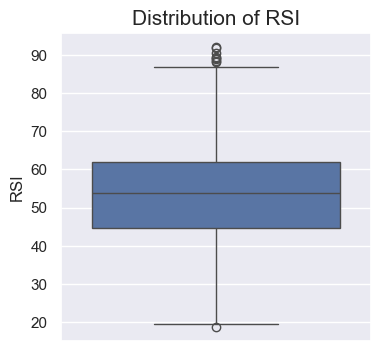

In [60]:
plotRSI(data_HNX30)

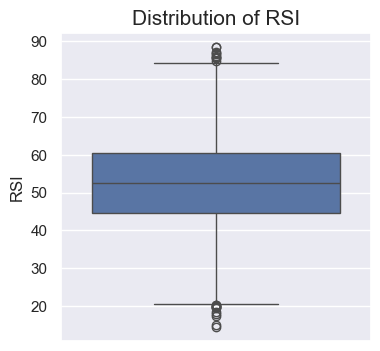

In [61]:
plotRSI(data_VN30)

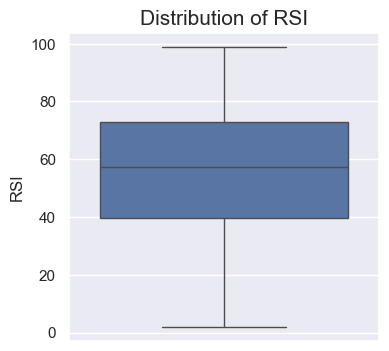

In [62]:
plotRSI(data_VNI)

## Correlation between attributes:

In [63]:
def plotHeatMap(data):
    corr_matrix_attributes = data.corr()

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_attributes, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

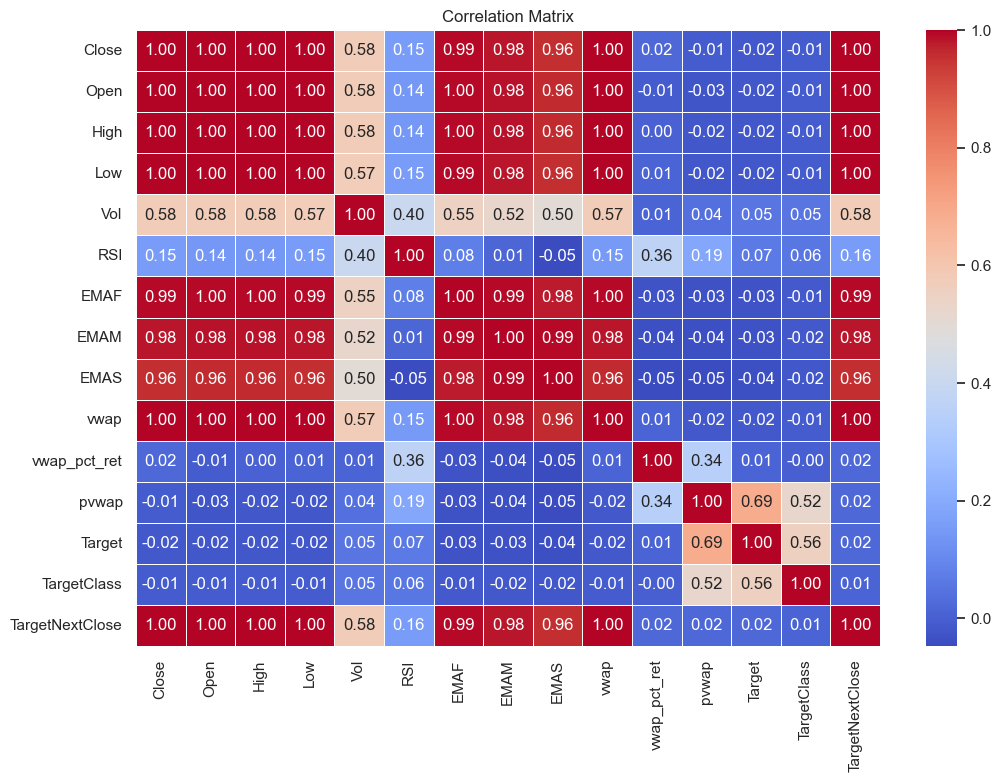

In [64]:
plotHeatMap(data_HNX30)

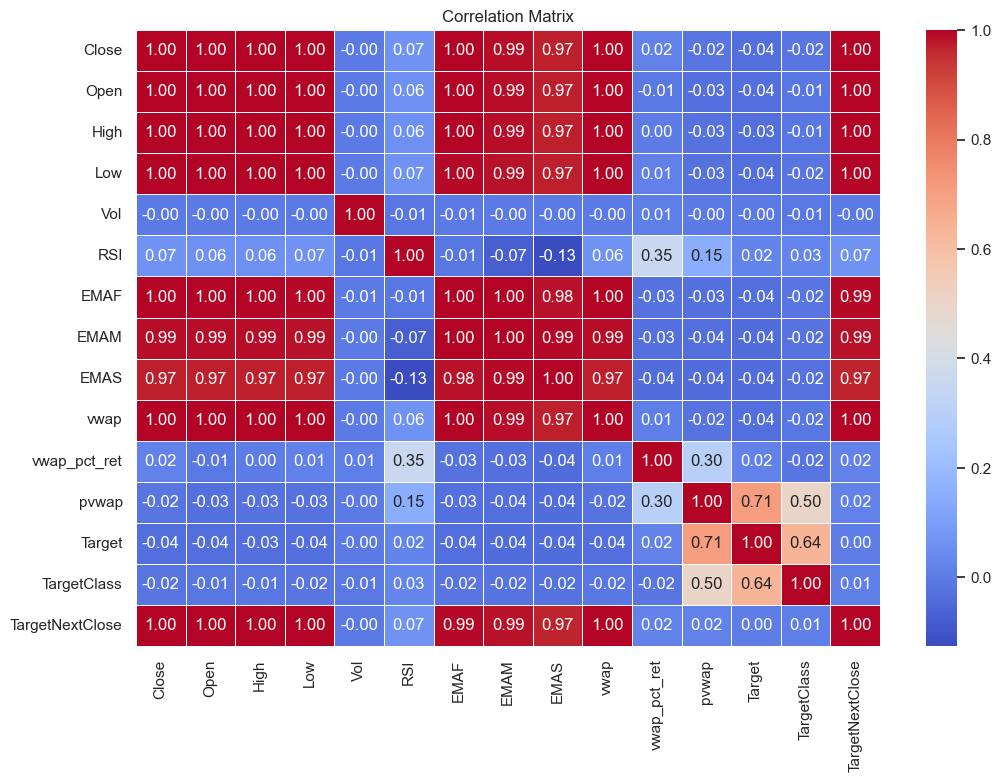

In [65]:
plotHeatMap(data_VN30)

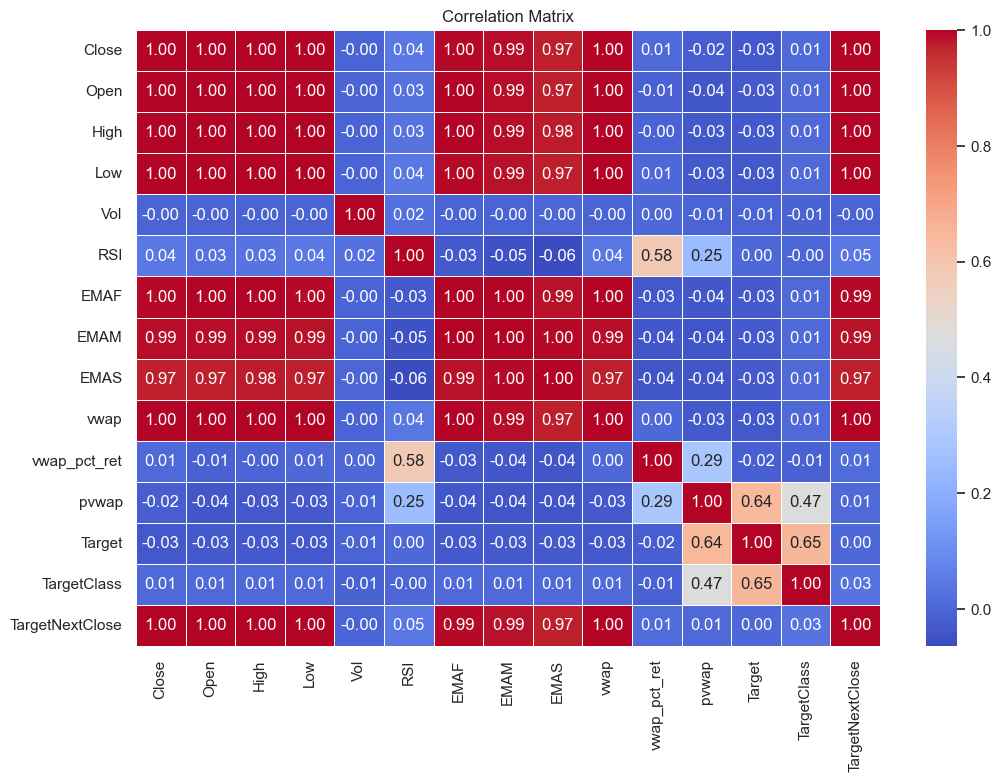

In [66]:
plotHeatMap(data_VNI)

### Scale data by Scikit StandardScaler

* NOTE: SCALE VN30 FIRST, OTHER INDICES DO THE SAME!

In [67]:
# !pip3 install scikit-learn

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
scaler = StandardScaler()
data_set = scaler.fit_transform(data_VN30)

In [70]:
print(data_set)

[[-0.99231096 -0.98903182 -0.9900561  ... -0.92209005 -1.05316425
  -1.01374611]
 [-1.01297111 -0.97641438 -0.98436847 ...  0.15601424  0.94951951
  -1.00564077]
 [-1.00486704 -1.01026944 -1.01570213 ...  0.6972994   0.94951951
  -0.98602099]
 ...
 [ 0.49101125  0.42638073  0.49189853 ...  0.42665682  0.94951951
   0.51339682]
 [ 0.51393219  0.49701058  0.52026773 ... -0.50317463 -1.05316425
   0.49374224]
 [ 0.4942807   0.51355576  0.51651045 ... -1.02748882 -1.05316425
   0.48292353]]


In [71]:
data_set.shape

(2396, 15)

### Create Dataset for training and testing

* X: Input set
* Y: Output set

Regression:

In [72]:
X_regression = data_set[:,:10]
X_regression.shape

(2396, 10)

In [73]:
y_regression =  data_set[:,-1]
y_regression.shape

(2396,)

Classification:

In [74]:
X_classification = data_set[:,:10]
X_classification.shape

(2396, 10)

In [75]:
y_classification = np.where(data_set[:,-1] > data_set[:,0], 1, 0)
y_classification.shape

(2396,)

LSTM:

In [76]:
X = []
# print(data_set[0].size) # => 11
backcandles = 11
# print(data_set.shape[0]) # => 2346

# get all columns except "Target",	"TargetClass",	"TargetNextClose"
for i in range(11):
    X.append([])
    for j in range(backcandles, data_set.shape[0]):
        X[i].append(data_set[j-backcandles:j,i]) # get each "backcandles" element from each column.

print("0:",X[0][0:1]) # first candle set of Close Price
print("1:",X[1][0:1]) # first candle set of Open Price


0: [array([-0.99231096, -1.01297111, -1.00486704, -0.98525034, -0.96685098,
       -0.98111135, -0.99140664, -1.01144073, -1.02396203, -1.05463922,
       -1.09025537])]
1: [array([-0.98903182, -0.97641438, -1.01026944, -1.01172931, -0.97738763,
       -0.95441207, -0.97516307, -0.99212535, -1.01357153, -1.02459006,
       -1.05413503])]


In [77]:
X = np.moveaxis(X,[0],[2]) # Transposition

In [78]:
X[0][:3]

array([[-0.99231096, -0.98903182, -0.9900561 , -0.98306712, -0.09361298,
         0.81789835, -1.03957831, -1.06560336, -1.08688034, -0.98863321,
        -0.55010239],
       [-1.01297111, -0.97641438, -0.98436847, -1.00000082, -0.08786308,
         0.46950959, -1.03674577, -1.06323572, -1.08515032, -0.99919997,
        -0.54771882],
       [-1.00486704, -1.01026944, -1.01570213, -1.00846767, -0.09379576,
         0.56278964, -1.0334087 , -1.06064012, -1.08328986, -1.00983633,
        -0.55388756]])

In [79]:
X_lstm = np.array(X)
y_lstm = np.reshape(np.array(data_set[backcandles:,-1]), (len(np.array(data_set[backcandles:,-1])),1))# LSTM got output from "backcandle"
# 1 col, with len(X)-backcandles rows

In [80]:
print("Shape",y_lstm.shape)
print(y_lstm)

Shape (2385, 1)
[[-1.07712776]
 [-1.0831111 ]
 [-1.0881204 ]
 ...
 [ 0.51339682]
 [ 0.49374224]
 [ 0.48292353]]


Because of ReLU Activation Function:

In [81]:
y_lstm = y_lstm + 2

### Split data

In [82]:
splitlimit = int(len(X_lstm)*0.8)
print("Split lim:",splitlimit)

Split lim: 1908


* Regression models train/test set:

In [83]:
X_train_regression, X_test_regression = X_regression[:splitlimit], X_regression[splitlimit:]
y_train_regression, y_test_regression = y_regression[:splitlimit], y_regression[splitlimit:]
print("Xtrain shape",X_train_regression.shape)
print("Xtest shape",X_test_regression.shape)
print("ytrain",y_train_regression.shape)
print("ytest",y_test_regression.shape)

Xtrain shape (1908, 10)
Xtest shape (488, 10)
ytrain (1908,)
ytest (488,)


* Classification models train/test set:

In [84]:
X_train_classification, X_test_classification = X_classification[:splitlimit], X_classification[splitlimit:]
y_train_classification, y_test_classification = y_classification[:splitlimit], y_classification[splitlimit:]
print("Xtrain shape",X_train_classification.shape)
print("Xtest shape",X_test_classification.shape)
print("ytrain",y_train_classification.shape)
print("ytest",y_test_classification.shape)

Xtrain shape (1908, 10)
Xtest shape (488, 10)
ytrain (1908,)
ytest (488,)


* LSTM train/test set:

In [85]:
X_train_lstm, X_test_lstm = X_lstm[:splitlimit], X_lstm[splitlimit:]
y_train_lstm, y_test_lstm = y_lstm[:splitlimit], y_lstm[splitlimit:]
print("Xtrain shape",X_train_lstm.shape)
print("Xtest shape",X_test_lstm.shape)
print("ytrain",y_train_lstm.shape)
print("ytest",y_test_lstm.shape)

Xtrain shape (1908, 11, 11)
Xtest shape (477, 11, 11)
ytrain (1908, 1)
ytest (477, 1)


## Summary

In [86]:
RSI_PARAMETER = 30

In [87]:
# csv file from https://vn.investing.com/indices
def pre_process(data):

    # rename
    data = rename(data)

    # reverse
    data = reverseData(data)

    # convert DataType
    data = convertDataType(data)
    
    # add Stock Indices:
    addRSI(data, RSI_PARAMETER)
    addEMA(data)
    addVWAP(data)
    
    # add Target
    addTarget(data)

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    return data

For Regression

In [88]:
def process_regression(data):
    X_regression = data[:,:11]
    y_regression = data[:,-1]
    return X_regression, y_regression

For Classifications:

In [89]:
def process_classification(data):
    X_classification = data[:,:11]
    y_classification = np.where(data[:,-1] > data[:,0], 1, 0)
    return X_classification, y_classification

For LSTM model:

In [90]:
def process_lstm(data, backcandles):
    X = []
    for i in range(11):
        X.append([])
        for j in range(backcandles, data.shape[0]):
            X[i].append(data[j-backcandles:j,i]) # get each "backcandles" element from each column.

    X = np.moveaxis(X,[0],[2]) # Transposition
    X_lstm = np.array(X)
    y_lstm = np.reshape(np.array(data[backcandles:,-1]), (len(np.array(data[backcandles:,-1])),1))# LSTM got output from "backcandle"
    y_lstm += 2
    return (X_lstm, y_lstm)

def split_dataset(X, y):
    split = int(0.8 * len(X))
    X_train, y_train = X[:split,:], y[:split,:]
    X_test, y_test = X[split:,:], y[split:,:]
    return X_train, y_train, X_test, y_test

# 3. Models

# Linear Regression

In [91]:
from sklearn.linear_model import LinearRegression

In [92]:
linear_reg = LinearRegression().fit(X_train_regression, y_train_regression)

# SVM

### Import Library

In [93]:
from sklearn.svm import SVC

### Fit SVM with train datasets

In [94]:
# Support vector classifier 
cls_rbf = SVC().fit(X_train_classification, y_train_classification)

cls_linear = SVC(kernel = 'linear').fit(X_train_classification, y_train_classification)

cls_poly = SVC(kernel = 'poly', degree = 2 ).fit(X_train_classification, y_train_classification)

# SVR

In [95]:
from sklearn.svm import SVR

In [96]:
# Support vector regression 

#rbf
svm_reg_rbf = SVR().fit(X_train_regression, y_train_regression)
#linear
svm_reg_linear = SVR(kernel='linear').fit(X_train_regression, y_train_regression)
#poly
svm_reg_poly = SVR(kernel='poly', degree=2).fit(X_train_regression, y_train_regression)

# LSTM 

## Background

Trong nhiều ứng dụng máy học, đặc biệt là trong xử lý dữ liệu chuỗi, việc duy trì và hiểu được mối quan hệ trong dữ liệu thời gian là quan trọng. Các mô hình truyền thống như mạng nơ-ron thuần (feedforward neural networks) thường không thể hiệu quả trong việc này do không giữ được thông tin liên tục qua thời gian.
 
LSTM là một dạng đặc biệt của mạng nơ-ron hồi quy (RNN - Recurrent Neural Network) được thiết kế để vượt qua vấn đề "mất mát thông tin" trong quá trình học dữ liệu thời gian.

### Forget Gate

LSTM sử dụng cổng quên để quyết định xem thông tin nào nên được giữ lại và thông tin nào nên bị loại bỏ từ bước thời gian trước đó.

$$\ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \$$

$$\ C_t = f_t \odot C_{t-1} \$$

### Input Gate

Cổng đầu vào quyết định thông tin mới nào sẽ được thêm vào trạng thái ẩn.

$$\ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \$$

$$ \tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) \$$

$$\ C_t = i_t \odot \tilde{C}_t \$$


### Output Gate

Cổng đầu ra quyết định thông tin nào sẽ được xuất ra từ trạng thái ẩn để làm đầu vào cho bước thời gian tiếp theo.

$$\ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \$$

$$\ h_t = o_t \odot \tanh(C_t) \$$

Trong các công thức trên:

- $\mathbf{f}_t$, $\mathbf{i}_t$, $\mathbf{o}_t$ là các vectơ cổng quên, đầu vào, và đầu ra tương ứng.
- $\sigma$  là hàm sigmoid, $\tanh$ là hàm tanh.
- $\mathbf{W}_f$, $\mathbf{W}_i$, $\mathbf{W}_o$, $\mathbf{W}_c$ là ma trận trọng số cho các cổng và trạng thái ẩn.
- $\mathbf{h}_{t-1}$, $\mathbf{x}_t$ là vector kết hợp giữa trạng thái ẩn từ bước thời gian trước đó $\mathbf{h}_{t-1}$ và đầu vào $\mathbf{x}_t$.
- $\mathbf{b}_f$, $\mathbf{b}_i$, $\mathbf{b}_o$, $\mathbf{b}_c$ là các vectơ độ lệch (bias).

Các biến:

- $\mathbf{C}_t$ là trạng thái ẩn (cell state) tại thời điểm $t$.
- $\tilde{\mathbf{C}}_t$ là thông tin mới được đề xuất cho trạng thái ẩn.
- $\mathbf{h}_t$ là trạng thái ẩn đầu ra tại thời điểm $t$.
- $\odot$ đại diện cho phép nhân element-wise (tích vô hướng).

### Import Libraries

In [97]:
# !pip3 install keras tensorflow

In [98]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.metrics import mean_squared_error
import numpy as np

2023-12-01 16:11:59.522533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Layers

In [99]:
def create_lstm_model(backcandles, X_train_lstm, y_train_lstm):
    lstm_input = Input(shape=(backcandles, 11), name='lstm_input')
    inputs = LSTM(150, name='first_layer')(lstm_input)  
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('relu', name='output')(inputs)
    lstm_model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam()
    lstm_model.compile(optimizer=adam, loss='mse')
    lstm_model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=20, epochs=40, shuffle=True, validation_split = 0.1)
    return lstm_model

def evaluate_backcandles():
    results = []
    backcandles_values = [2*i for i in range(3,13)]
    for backcandles in backcandles_values:
        X_lstm, y_lstm = process_lstm(data=data_set,backcandles=backcandles)
        X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = split_dataset(X_lstm, y_lstm)

        print(f"Evaluating backcandles={backcandles}")
        model = create_lstm_model(backcandles, X_train_lstm, y_train_lstm)
        
        # Assuming you have X_test_lstm, y_test_lstm for evaluation
        y_pred = model.predict(X_test_lstm)
        mse = mean_squared_error(y_test_lstm, y_pred)
        results.append((backcandles, mse, model))
    return results

def get_best_backcandles(results):
    # results is an array wth triples (backcandles and mse and model)
    return min(results, lambda x: x[1])[:]

In [100]:
result = (evaluate_backcandles())

Evaluating backcandles=6
Epoch 1/40
86/86 [==============================] - 4s 16ms/step - loss: 0.7472 - val_loss: 0.0219
Epoch 2/40
86/86 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 3/40
86/86 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0082
Epoch 4/40
86/86 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 5/40
86/86 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0083
Epoch 6/40
86/86 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0091
Epoch 7/40
86/86 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0096
Epoch 8/40
86/86 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 9/40
86/86 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 10/40
86/86 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 

In [101]:
minimize = 1
idx = 2

for i in range(2,len(result)):
    if minimize > result[i][1]:
        minimize = result[i][1]
        idx = i


backcandles = 2*(i+1)
lstm_model = result[idx][2]

# 4. Model evaluation

# Linear Regression

In [102]:
y_pred_linear_reg = linear_reg.predict(X_test_regression)

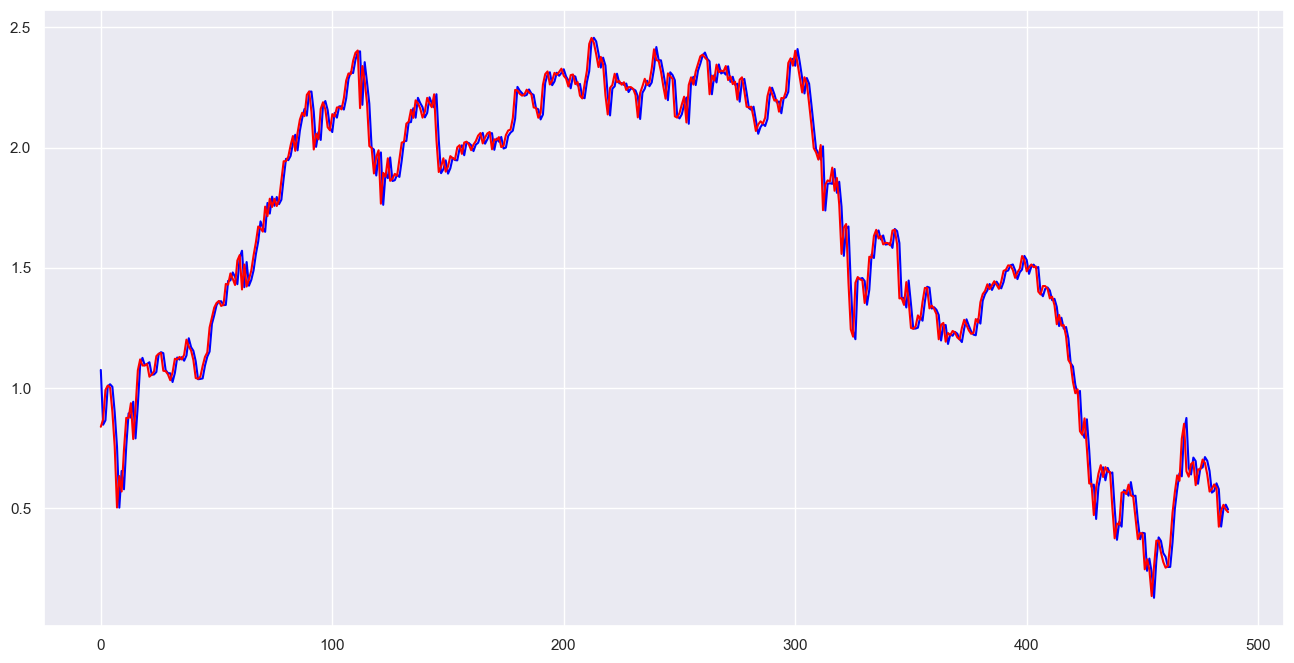

In [103]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_linear_reg,color='blue',label='pred') 
plt.plot(y_test_regression,color='red',label='pred') 

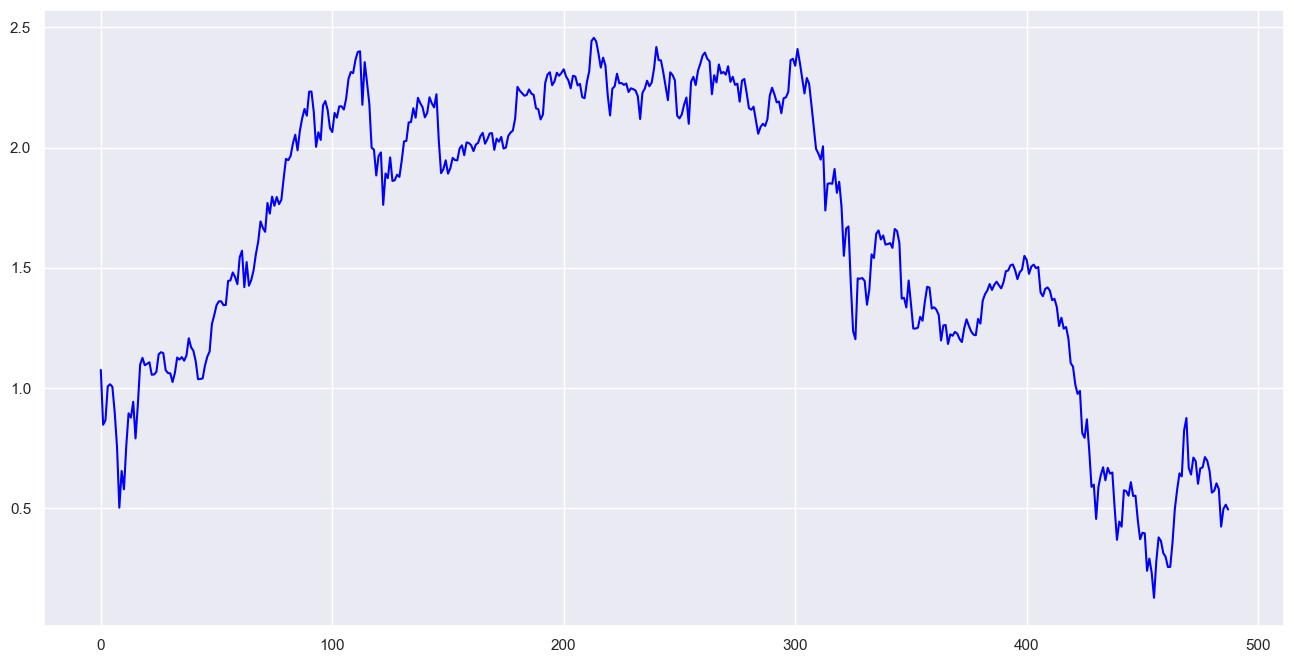

In [104]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_linear_reg,color='blue',label='pred') 

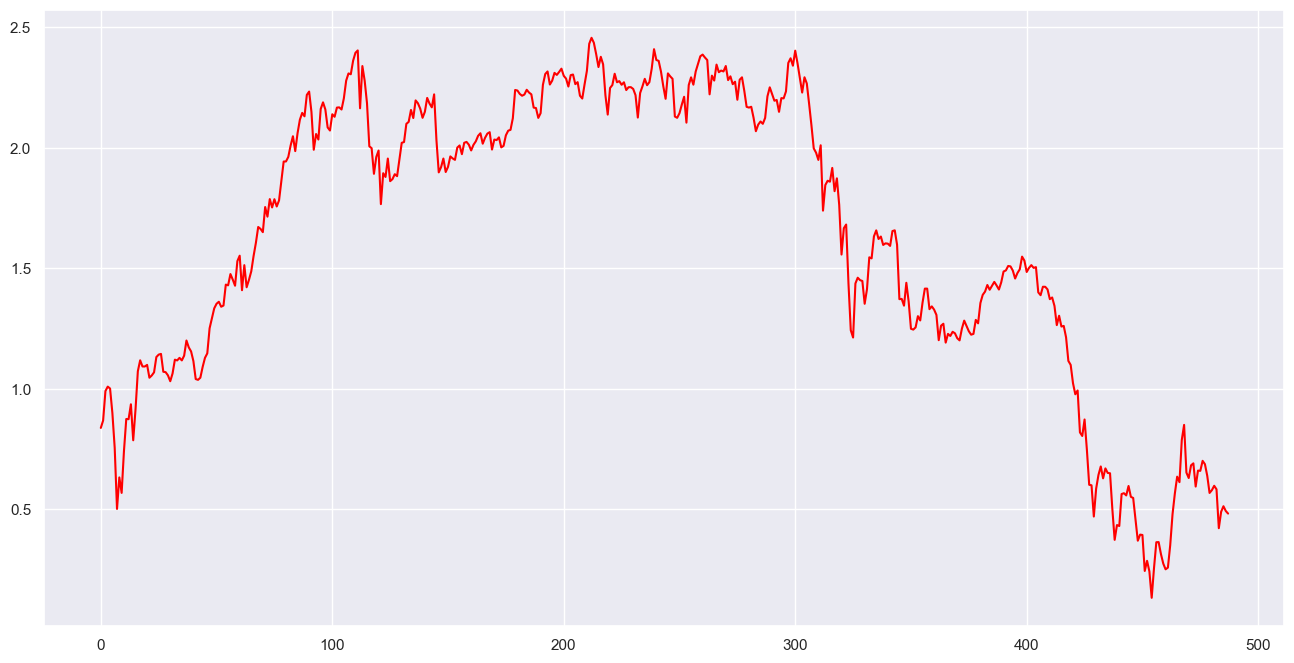

In [105]:
plt.figure(figsize=(16,8)) 
plt.plot(y_test_regression,color='red',label='pred') 

In [106]:
mean_squared_error(y_pred_linear_reg, y_test_regression)

0.0046932074618599336

## SVM

Predict test dataset:

In [107]:
y_pred_svm_linear = cls_linear.predict(X_test_classification)
y_pred_svm_rbf = cls_rbf.predict(X_test_classification)
y_pred_svm_poly = cls_poly.predict(X_test_classification)

Calculate **accuracy_score**:

In [108]:
from sklearn.metrics import accuracy_score

In [109]:
print(accuracy_score(y_pred_svm_linear, y_test_classification))

0.5122950819672131


In [110]:
data_svm = data_VN30.copy()
data_svm['Predicted_Signal'] = cls_linear.predict(X_classification)

data_svm['Signal'] = np.where(data_svm['TargetNextClose']>data_svm['Close'], 1, 0)

In [111]:
print(accuracy_score(data_svm['Predicted_Signal'], data_svm['Signal']))

0.5459098497495827


* Calculate daily returns:

In [112]:
data_svm['Return'] = data_svm.Close.pct_change()

In [113]:
data_svm.dropna(inplace=True)

* Calculate Strategy Returns:

In [114]:
data_svm['Strategy_Return'] = data_svm.Return * data_svm.Predicted_Signal.shift(1)

* Calculate Cumulative Returns:

In [115]:
data_svm['Cum_Ret'] = data_svm['Return'].cumsum() 

* Calculate Strategy Cumulative Returns:

In [116]:
data_svm['Cum_Strategy'] = data_svm['Strategy_Return'].cumsum() 
data_svm

,Close,Open,High,Low,Vol,RSI,EMAF,EMAM,EMAS,vwap,...,pvwap,Target,TargetClass,TargetNextClose,Predicted_Signal,Signal,Return,Strategy_Return,Cum_Ret,Cum_Strategy
1,574.95,585.29,586.74,574.95,25990,58.400160,567.238196,558.428928,550.960046,578.880000,...,-0.005280,1.73,1,577.28,1,1,-0.010226,NaN,-0.010226,NaN
2,577.28,575.55,577.65,572.54,18200,59.490218,568.194559,559.168186,551.481233,575.823333,...,0.008266,7.79,1,582.92,1,1,0.004053,0.004053,-0.006173,0.004053
3,582.92,575.13,583.70,575.13,24810,62.025628,569.596982,560.099630,552.103783,580.583333,...,0.010507,3.20,1,588.21,1,1,0.009770,0.009770,0.003597,0.013822
4,588.21,585.01,588.21,583.63,24170,64.235625,571.369650,561.201997,552.818757,586.683333,...,0.000761,-7.51,0,584.11,1,0,0.009075,0.009075,0.012672,0.022897
5,584.11,591.62,593.17,584.11,24220,61.323995,572.583017,562.100350,553.438386,587.130000,...,-0.008317,-4.50,0,581.15,1,0,-0.006970,-0.006970,0.005701,0.015927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,1034.13,1037.91,1041.37,1022.51,129850,49.353383,1038.186845,1045.911207,1101.204012,1032.670000,...,-0.028825,-44.65,0,987.77,1,0,-0.004055,-0.004055,0.748375,0.772245
2392,987.77,1032.42,1033.17,987.77,175230,42.598764,1033.385241,1043.631159,1098.957793,1002.903333,...,-0.000223,18.49,1,1007.36,1,1,-0.044830,-0.044830,0.703545,0.727416
2393,1007.36,988.87,1015.01,985.67,153660,45.892643,1030.906646,1042.208761,1097.143976,1002.680000,...,0.008733,4.76,1,1013.95,1,1,0.019833,0.019833,0.723378,0.747248
2394,1013.95,1009.19,1023.24,997.12,123260,46.970184,1029.291728,1041.100574,1095.496570,1011.436667,...,0.001463,-5.65,0,1008.30,1,0,0.006542,0.006542,0.729920,0.753790


In [117]:
def classification_evaluation(model, dataframe, X):
    data_svm = dataframe.copy()
    data_svm['Predicted_Signal'] = model.predict(X)
    data_svm['Signal'] = np.where(data_svm['TargetNextClose'] > data_svm['Close'], 1, 0)
    data_svm['Return'] = data_svm.Close.pct_change()
    data_svm.dropna(inplace=True)
    data_svm['Strategy_Return'] = data_svm.Return * data_svm.Predicted_Signal.shift(1)
    data_svm['Cum_Ret'] = data_svm['Return'].cumsum() 
    data_svm['Cum_Strategy'] = data_svm['Strategy_Return'].cumsum() 

    plt.figure(figsize=(16,8))
    plt.plot(data_svm['Cum_Ret'],color='red',label= 'test') 
    plt.plot(data_svm['Cum_Strategy'],color='blue',label='pred')
    return

* Plot Strategy Returns vs Original Returns:

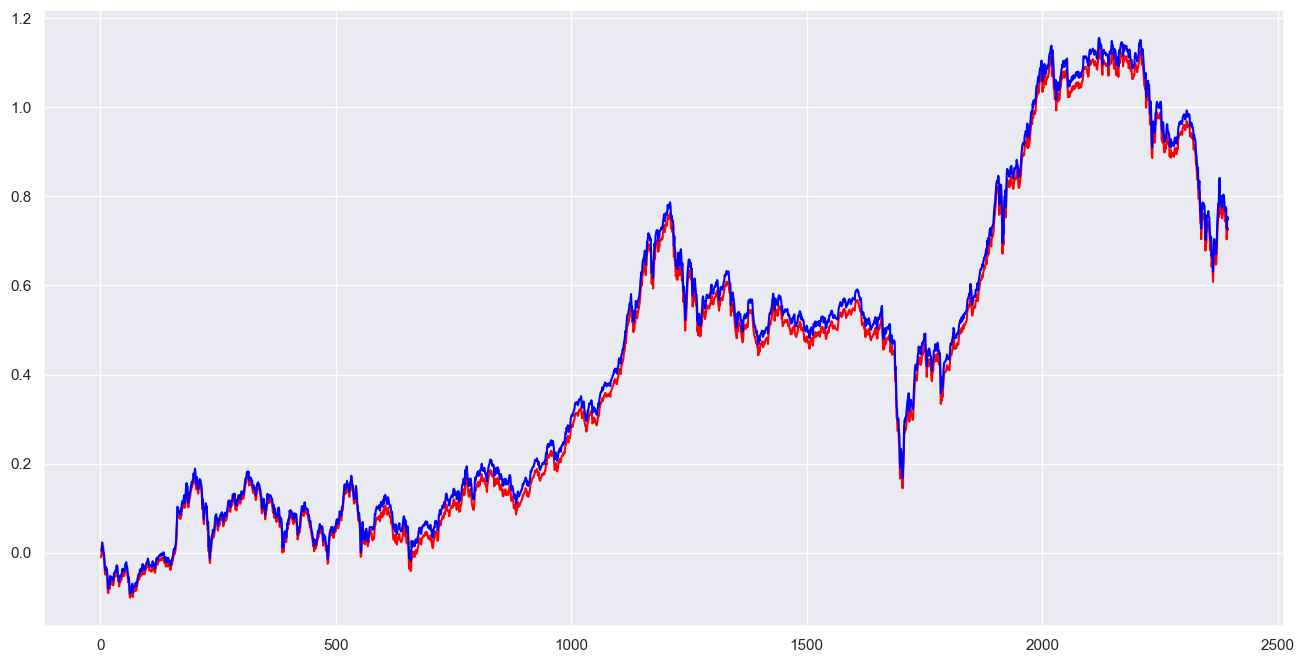

In [118]:
plt.figure(figsize=(16,8))
plt.plot(data_svm['Cum_Ret'],color='red',label= 'test') 
plt.plot(data_svm['Cum_Strategy'],color='blue',label='pred')

In [119]:
plt.figure(figsize=(16,8))


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

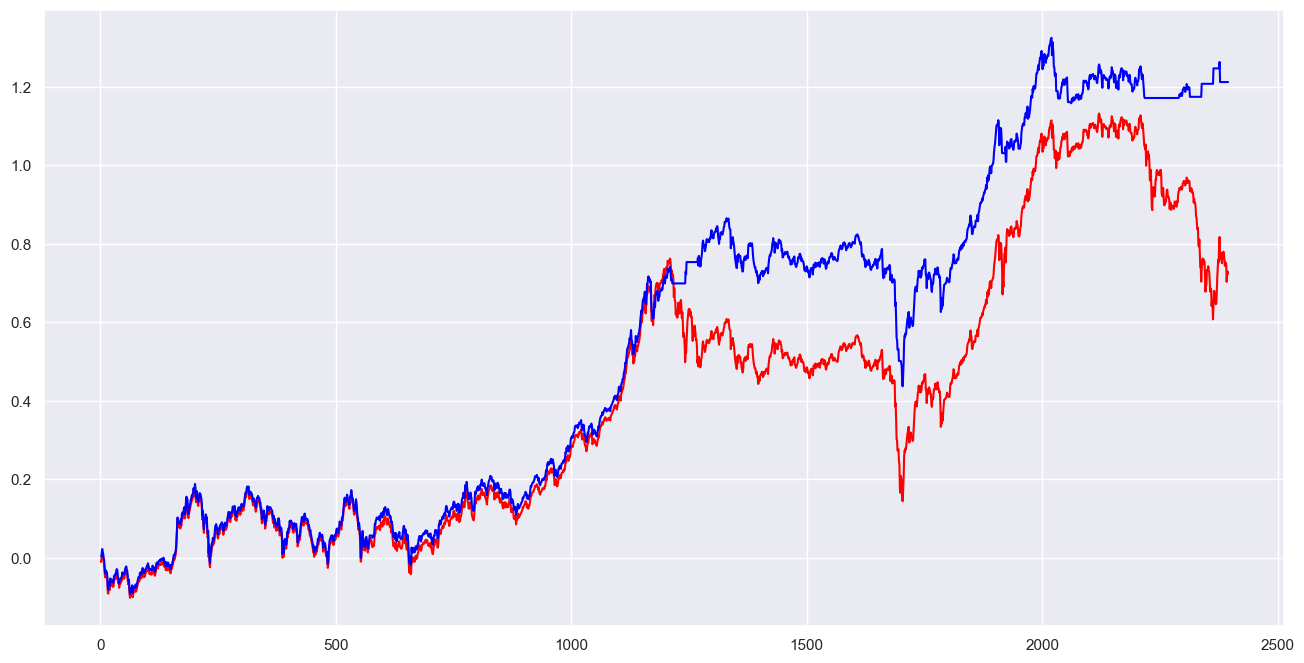

In [120]:
classification_evaluation(cls_rbf, data_VN30, X_classification)

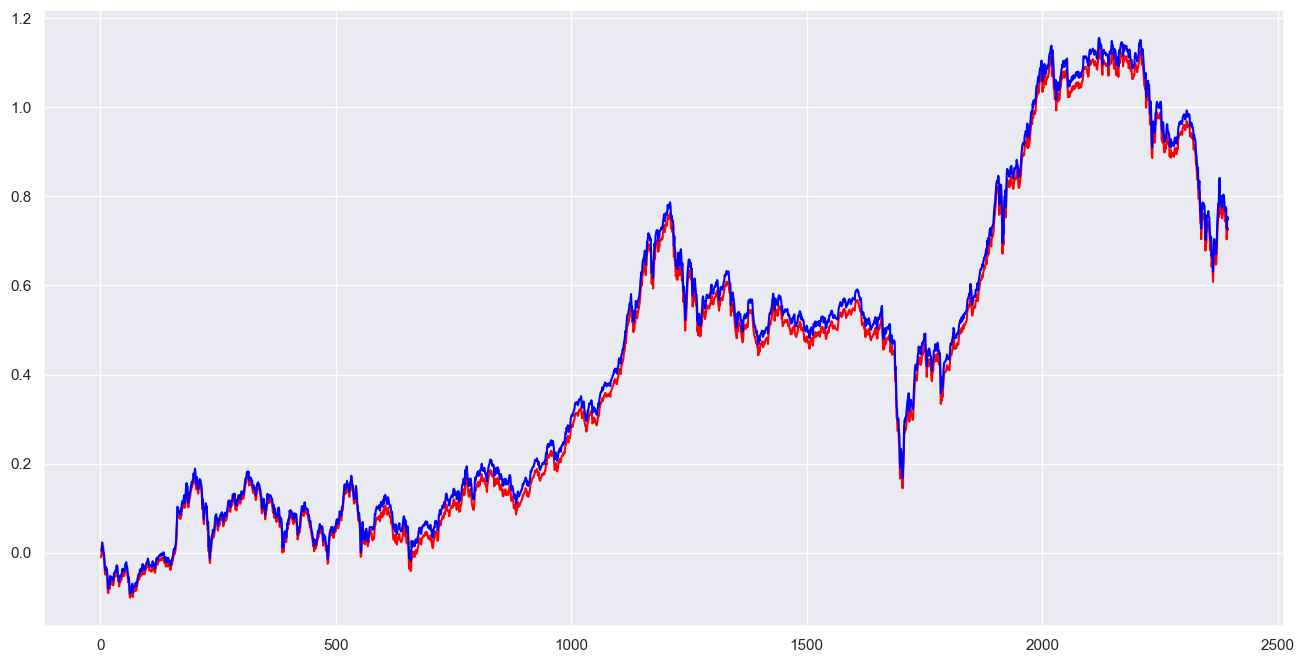

In [121]:
classification_evaluation(cls_poly, data_VN30, X_classification)

# SVR

In [122]:
#rbf
y_pred_svr_rbf = svm_reg_rbf.predict(X_test_regression)

#linear
y_pred_svr_linear = svm_reg_linear.predict(X_test_regression)

#poly
y_pred_svr_poly = svm_reg_poly.predict(X_test_regression)

### RBF

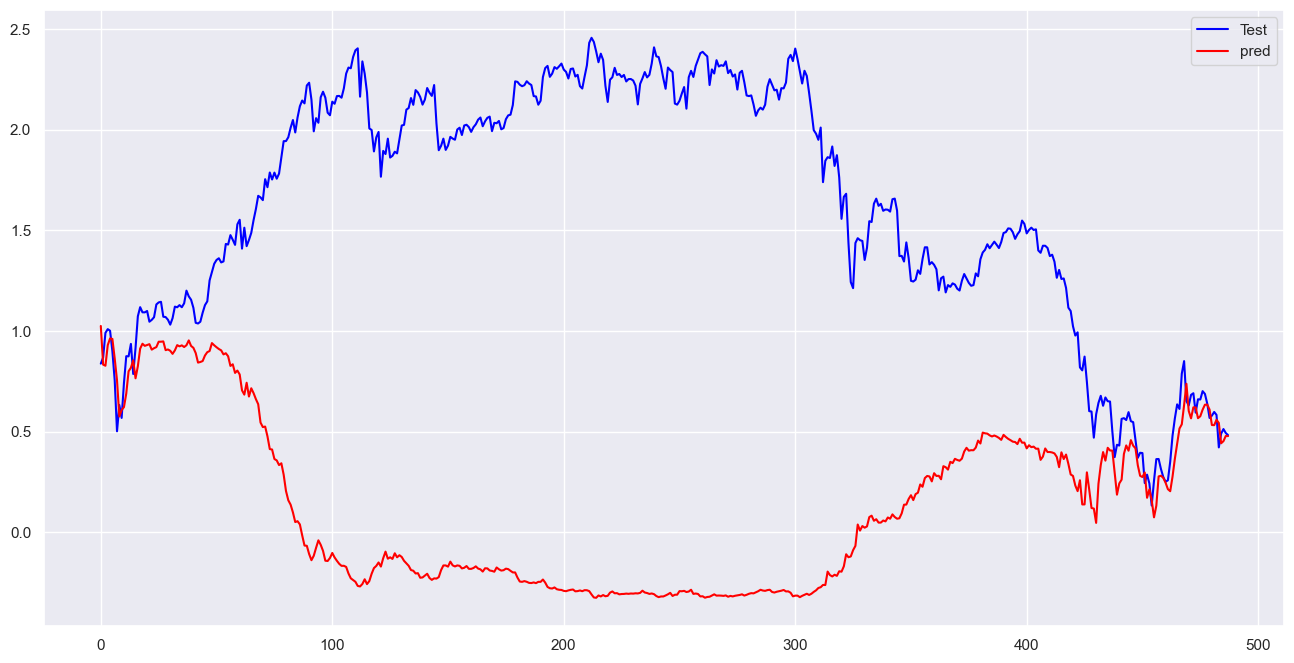

In [124]:
plt.figure(figsize=(16,8))
plt.plot(y_test_regression, color = 'blue', label = 'Test')
plt.plot(y_pred_svr_rbf, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [126]:
mean_squared_error(y_pred_svr_rbf,y_test_regression)

3.193165293082233

### Linear

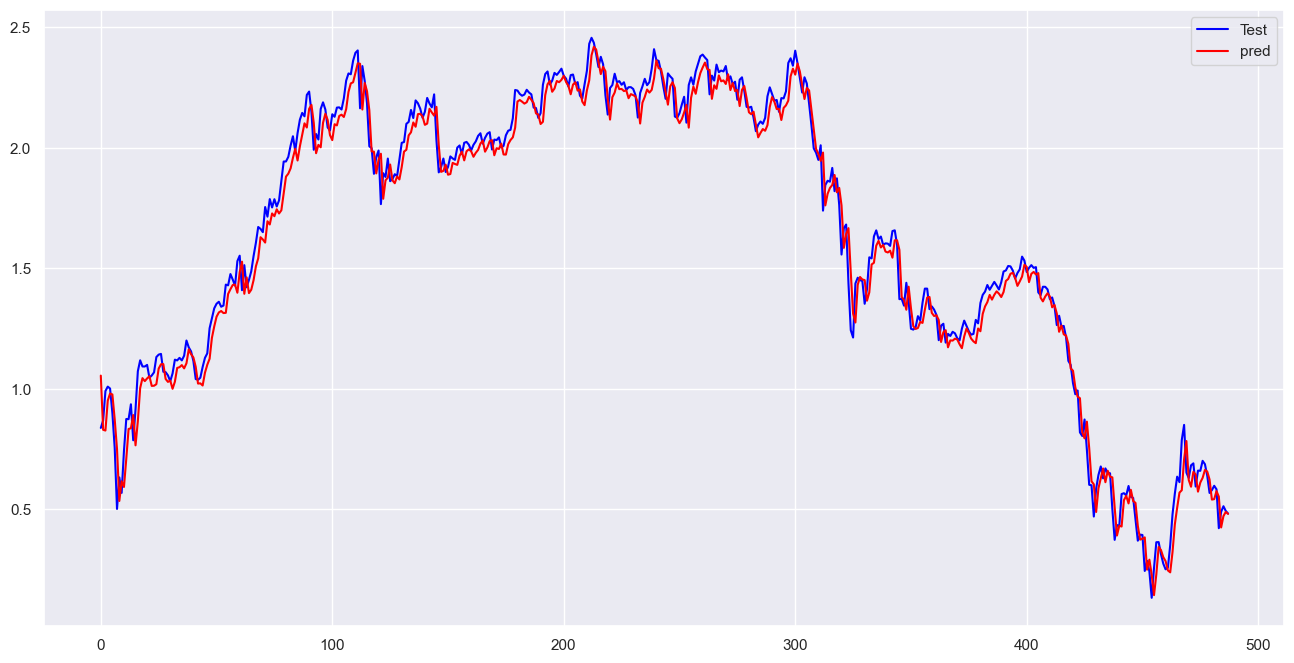

In [127]:
plt.figure(figsize=(16,8))
plt.plot(y_test_regression, color = 'blue', label = 'Test')
plt.plot(y_pred_svr_linear, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [128]:
mean_squared_error(y_pred_svr_linear,y_test_regression)

0.0056477085456062455

### Poly

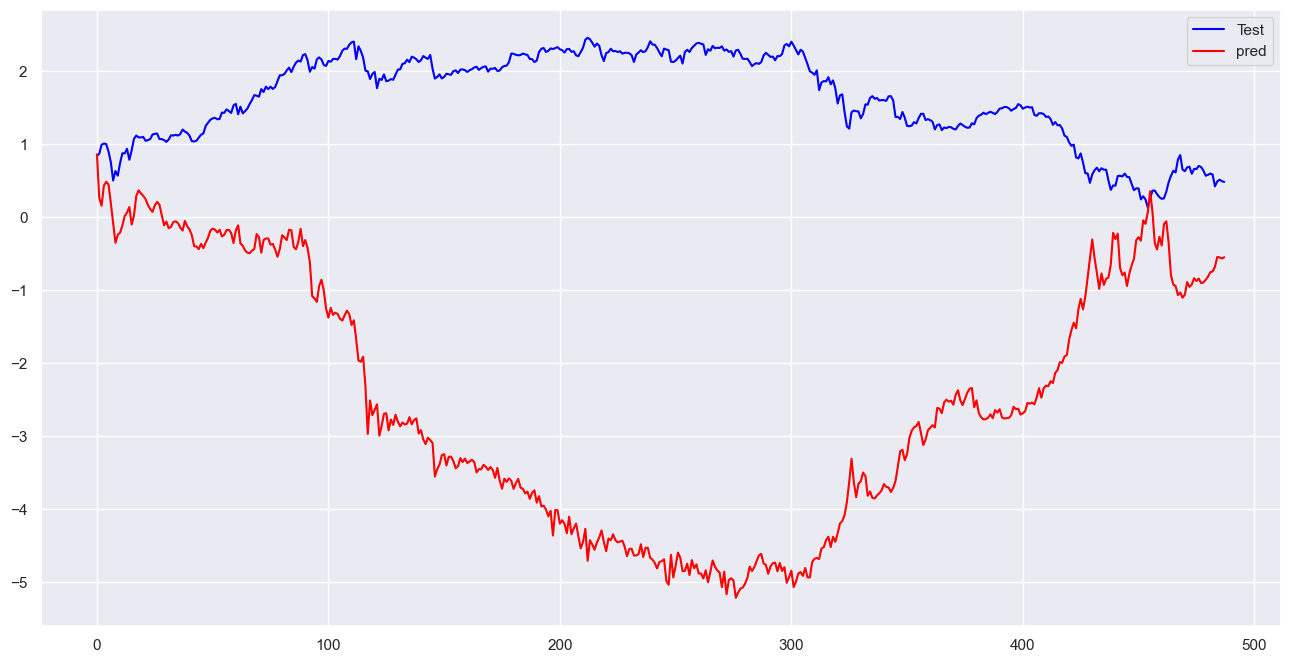

In [129]:
plt.figure(figsize=(16,8))
plt.plot(y_test_regression, color = 'blue', label = 'Test')
plt.plot(y_pred_svr_poly, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [130]:
mean_squared_error(y_pred_svr_poly,y_test_regression)

22.0981658659009

## LSTM

In [131]:
y_pred_lstm = lstm_model.predict(X_test_lstm)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred_lstm[i], y_test_lstm[i])

15/15 [==============================] - 1s 6ms/step
[2.617041] [2.87528447]
[2.7375035] [2.87444958]
[2.9067998] [2.93623104]
[2.9293208] [2.78696064]
[2.9775467] [2.91532414]
[2.8766165] [3.07332603]
[2.9001253] [3.1186533]
[3.0534348] [3.09308497]
[3.1103992] [3.09294582]
[3.0943546] [3.09962489]


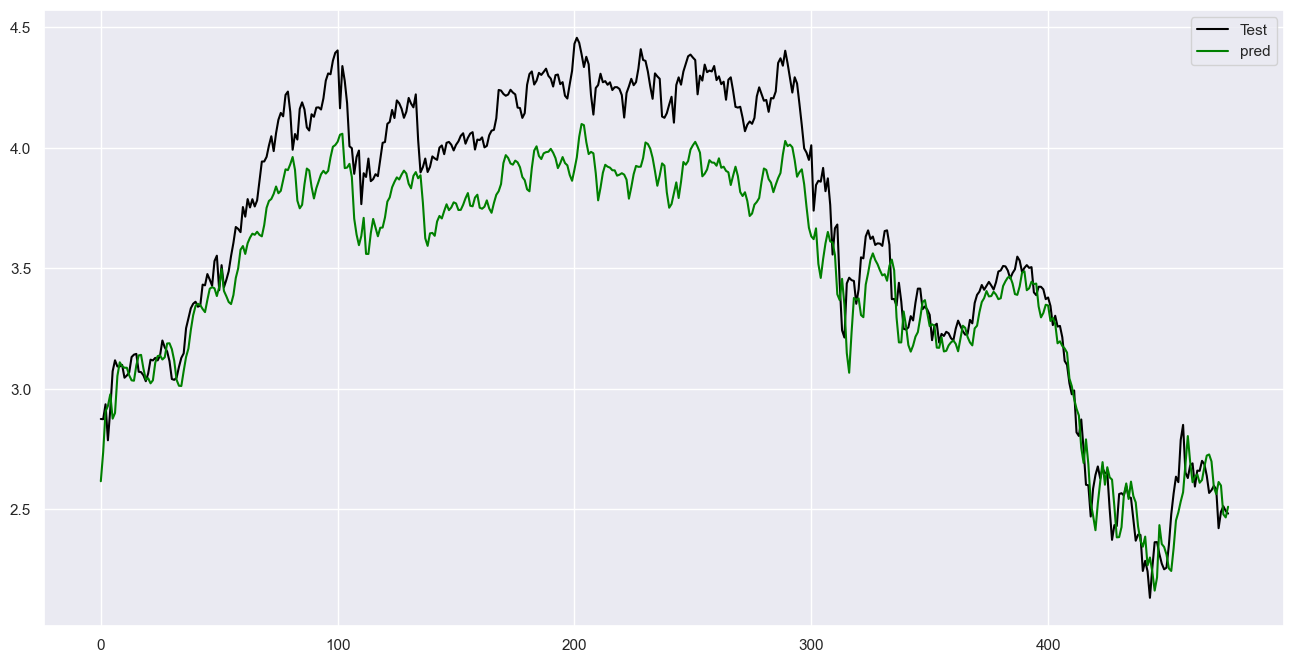

In [132]:
plt.figure(figsize=(16,8))
plt.plot(y_test_lstm, color = 'black', label = 'Test')
plt.plot(y_pred_lstm, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [133]:
mean_squared_error(y_pred_lstm,y_test_lstm)

0.059543673922975146

# 5. References
1. https://vnexpress.net/chi-bao-rsi-la-gi-4481781.html